### Embedding and Cosine Similarity

In this section we are collecting the sequences to embed them using a Pretrained model from Rostlab's [ProtTrans](https://github.com/agemagician/ProtTrans). After this embedding the cosine similarity of each embedded protein sequence is achieved and graphed as a heatmap.

In [1]:
# BioPython library for collecting the sequences from cif files
from Bio.PDB import PDBList
from Bio.PDB.MMCIFParser import MMCIFParser

In [2]:
# Data manipulation libraries
import os
import io
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pyspark libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.types import ArrayType, DoubleType, MapType, FloatType
from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.ml.functions import vector_to_array


In [3]:
# Creating the spark session
spark = SparkSession.builder \
    .master("spark://master:7077")\
    .appName("Proteindata spark application")\
    .config("spark.dynamicAllocation.enabled", "false")\
    .config("spark.driver.host", "10.67.22.219") \
    .config("spark.driver.port","6066")\
    .config("spark.executor.memory", "4g")\
    .config("spark.executor.cores","4")\
    .config("spark.sql.optimizer.enableRangeJoin", "true")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/08 11:00:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Creating the spark context
sc = spark.sparkContext

### Getting the file paths

In [5]:
# Getting the file paths
base_path = '/data_files/pdb_files'
base_path_edit = '/data_files/pdb_files/{}'
file_names = os.listdir(base_path)
file_list = [base_path_edit.format(i) for i in file_names][:400]
files_rdd = sc.parallelize(file_list)#numSlices=12

In [6]:
# Counting all of the paths to see if there are any errors
files_rdd.count()

400

In [7]:
#files_rdd.coalesce(12)
files_rdd.getNumPartitions()

12

### Parsing the file

#### Parsing the files using the Biopython library to get the sequence. The output of this function is the id of the protein, sequence and the length. 

In [8]:
def parse_file(file):

    cif_parser = MMCIFParser(QUIET=True) # CIF file parser
    length = 0 # Setting the length initially to 0 for error correction
    name = file.split('/')[3].split('.')[0] # Getting the id of the protein
    structure = cif_parser.get_structure("protein", file) # getting structure ? try "protein"

    # Dictionary for residue names
    d3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
    'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
    'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
    'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

    # Creating the sequence   
    for model in structure:
        for chain in model:
            sequence = [d3to1.get(residue.get_resname(), 'X') for residue in chain.get_residues()]
            length = len(sequence)
    
    return name,sequence,length

### Creating a dataframe 
#### A dataframe containing the id, length and the token of the each sequence

In [9]:
# Creating an RDD for the tokens
def tokens_df_creator(file_path):

    data = []
    name, sequence, length = parse_file(file_path)
    row_value = {
        'id':name,
        'length':length,
        'tokens':sequence, # sequence is tokenized like ["A","B","K",...] (each residue is a token)
    }
    data.append(Row(**row_value)) # Creating rows containing id, length and the sequence of each file in the folder
    
    return data

# Turning the RDD into a DF for easier usage
tokens_rdd = files_rdd.flatMap(tokens_df_creator) # FlatMap applied to the RDD
tokens_df = tokens_rdd.toDF()

#### Checking output

In [ ]:
tokens_df.take(1)

In [ ]:
#Checking if there is any missing data
tokens_df.where(tokens_df.length==0).show()

### Creating the .vec file using ProtBert

#### Here I shortly showed what I did in order to achieve the .vec file. Since the ProtBert model didn't have such file I looped through the residues and created the vocabulary. 

```python
import numpy as np
#transformer model for embedding space creation
from transformers import BertModel, BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False ) # change model and tokenizer to t5
model_embedd = BertModel.from_pretrained("Rostlab/prot_bert")

vocab = ['L','A','G','V','E','S','I','K','R','D','T','P','N','Q','F','Y','M','H','C','W','X','U','B','Z','O']
# Path to save the .vec file
vec_file_path = 'prot_bert.vec'

# Open the file in write mode
with open(vec_file_path, 'w') as f:
    # Write the header (vocab size and vector dimension)
    f.write(f"{len(vocab)} {outputs.last_hidden_state.size()[2]}\n")
    
    # Write each word and its corresponding vector
    for letter in vocab:
        encoded_input = tokenizer.encode(letter,return_tensors='pt').to(device)
        outputs = model_embedd(input_ids=encoded_input)
        vector = outputs.last_hidden_state[0,0].detach().numpy()
        vector_str = ' '.join(map(str, vector))  # Convert the vector to a string
        f.write(f"{letter} {vector_str}\n")
```

#### The problem with this implementation is that all the semantic information between the residues in a sequence is lost since the .vec file is created for each residue. This is highly affecting our output since this semantic knowledge contain ancestoral, functional, structural and many more information.

### Loading the embedding pre_trained model

#### We loaded the .vec file as a standard python dictionary which is at first only available in the driver node. But using the Pyspark's broadcast function this dictionary can be broadcasted to all of the nodes which enables the executors to have the dictionaries in their local environment.

In [10]:
# Creating the dictionary from the .vec file
# .vec file contains the keys (residues) and their corresponding embedding with size 1024
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    data = {}
    for line in fin:
        letter_token = line.rstrip().split()
        # For each residue creating a DenseVector containing the embedding obtained from the .vec file
        data[letter_token[0]] = DenseVector([float(letter) for letter in letter_token[1:]]) 
    return data

vec_dict = load_vectors('/data_files/prot_bert.vec')

### Broadcasting
Using the broadcast from the SparkContext created dictionary (containing the information coming from the .vec file) is broadcasted through the cluster. With this broadcasting during the action where the transformation to create the embedding occurs, each executor can use their local dictionary to create the embeddings. 

In [11]:
# Broadcasting the dictionary
vec_broadcast = sc.broadcast(vec_dict)

### Creating list of vectors

In [12]:
# Embedding the sequence
# The embedding is done using a UDF
@F.udf(ArrayType(VectorUDT()))
def embed_sequence(tokens_list):
    return [vec_broadcast.value[token] for token in tokens_list if token in vec_dict]


In [13]:
# The embeddings are added as a new column (UDF applied to the DataFrame)
tokens_df = tokens_df.withColumn("embeddings",embed_sequence(tokens_df.tokens))

##### The size of the embeddings are 1024 x len(seq)

#### Output check

In [ ]:
tokens_df.where(tokens_df.embeddings == None).show()

In [ ]:
tokens_df.take(1)
#  mins

### Taking the mean of the list of the vectors (len(sequence) x 1024) to achieve one vector with length 1024

##### To reduce the dimensions of the embeddings we used the same aproach as Rostlab did, in order to achieve an embedding for the protein sequence.


In [14]:
# Creating another udf to get the mean of each embedding row
@F.udf(VectorUDT())
def mean_calculator(embedding,length):
    mean_embedding = sum(embedding)/length # getting the mean of the embeddings in axis=0
    return mean_embedding   

# Created mean embedding is added as a new column
tokens_df = tokens_df.withColumn("mean_embed",mean_calculator(tokens_df.embeddings,tokens_df.length))

In [15]:
# Selecting a subset of the tokens_df
mean_embed_df = tokens_df.select("id","mean_embed")

#### Checking output

In [ ]:
mean_embed_df.filter(F.col("mean_embed").isNull()).show()

In [ ]:
take5 = mean_embed_df.take(5)

In [ ]:
print(len(take5[3][1]))

In [ ]:
print(take5[1][0])

### Cosine similarity

#### Here we created another udf for the calculation of the cosine similarity for each protein sequence. With this we can see if there are any similarities between protein sequences.

In [16]:
# Creating 2 views from the same mean_embed_df
mean_embed_df.withColumnRenamed('id', 'id1').withColumnRenamed('mean_embed', 'embed_1').createOrReplaceTempView("df1")

mean_embed_df.withColumnRenamed('id', 'id2').withColumnRenamed('mean_embed', 'embed_2').createOrReplaceTempView("df2")

# Using sql to join the dfs using a condition which reduces the number of unnecessary calculation
# caused by the joining 2 dfs to create all the possible pairs
joined_df = spark.sql(
"""SELECT *
FROM df1, df2
WHERE df1.id1 < df2.id2""") # using this condition we are creating only the upper triangle of the expected cross joined "matrix"

In [ ]:
joined_df.take(1)

In [17]:
# Convert DenseVector to an array
joined_df = joined_df.withColumn("embed_1", vector_to_array(F.col("embed_1")))
joined_df = joined_df.withColumn("embed_2", vector_to_array(F.col("embed_2")))

In [ ]:
joined_df = joined_df.coalesce(144)

In [18]:
# Compute dot product, norms, and cosine similarity directly
df_cos_sim = (
    joined_df.withColumn("dot_prod", F.expr("aggregate(zip_with(embed_1, embed_2, (x, y) -> x * y), 0D, (acc, v) -> acc + v)"))
      .withColumn("norm_1", F.expr("sqrt(aggregate(embed_1, 0D, (acc, v) -> acc + v * v))"))
      .withColumn("norm_2", F.expr("sqrt(aggregate(embed_2, 0D, (acc, v) -> acc + v * v))"))
      .withColumn("cosine_similarity", F.col("dot_prod") / (F.col("norm_1") * F.col("norm_2")))
      .drop("dot_prod", "norm_1", "norm_2","embed_1","embed_2")
)

In [ ]:
def cos_sim(a,b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

# apply the UDF to the column
joined_df = joined_df.withColumn("coSim", F.udf(cos_sim, FloatType())(F.col("embed_1"), F.col("embed_2"))

In [19]:
df_cos_sim.persist()
df_cos_sim.take(2)

[Row(id1='2kgj', id2='7csq', cosine_similarity=0.9953106710572059),
 Row(id1='2kgj', id2='2msx', cosine_similarity=0.9981249358863621)]

In [ ]:
df_cos_sim.explain(True)

In [20]:
# Filtering the data since being really close to 1 is not surprising
filtered_df = df_cos_sim.filter("cosine_similarity < 0.969")
#F.col("cosine_similarity").isNotNull() &

In [21]:
filtered_df.count()


33

In [ ]:
filtered_df = filtered_df.coalesce(12)

Getting the unique ids to create the heatmap

#### Creating the matrix for creating the heatmap easily with filtered data

In [22]:
# Using Spark DataFrame operations for efficiency
idx_df = filtered_df.select('id1').union(filtered_df.select('id2')).distinct()

# Collecting the unique IDs
idx = [row['id1'] for row in idx_df.collect()]


In [23]:
len(idx)

18

In [ ]:
# Collecting unique id values
row_idx1 = filtered_df.select('id1').distinct().rdd.map(lambda r: r[0]).collect()
row_idx2 = filtered_df.select('id2').distinct().rdd.map(lambda r: r[0]).collect()
idx = list(set(row_idx1 + row_idx2))

In [24]:
# Collecting the embeddings of the unique id's and creating a new dataframe containing only these id's
filtered_mean_embed_df = mean_embed_df.filter(mean_embed_df["id"].isin(idx) == True)

In [25]:
filtered_mean_embed_df.collect()

[Row(id='2lg4', mean_embed=DenseVector([0.0371, 0.0334, -0.0552, -0.2191, 0.1597, -0.0712, -0.0279, -0.0631, -0.0677, -0.0275, 0.0325, 0.0699, -0.0359, 0.0677, 0.064, -0.1091, -0.029, 0.0862, -0.0058, -0.0393, 0.0514, 0.114, -0.0619, -0.0503, 0.0332, 0.0219, -0.0417, 0.0084, 0.0575, -0.0402, -0.043, 0.0829, -0.0506, -0.0194, 0.0545, -0.0325, 0.0302, 0.0727, -0.1125, -0.109, 0.0879, 0.124, 0.0771, 0.0374, 0.0399, -0.2272, 0.0902, -0.0471, 0.0471, 0.0406, 0.0111, -0.0781, -0.0378, -0.1437, 0.0037, 0.0303, 0.0004, -0.1402, -0.0391, -0.0351, -0.0855, -0.0724, 0.0585, -0.0211, -0.0669, -0.0448, -0.0339, -0.0004, 0.1307, -0.0536, -0.1381, 0.042, -0.0291, -0.052, 0.0498, -0.0567, -0.0814, 0.0231, 0.0488, 0.0378, 0.0101, 0.0729, 0.0276, 0.0446, 0.0664, -0.093, -0.0801, -0.1257, 0.2141, -0.0417, -0.0035, -0.0923, -0.0143, -0.1036, -0.0189, 0.109, 0.2846, 0.0095, 0.1202, 0.0338, -0.0563, 0.0079, -0.0561, 0.0381, 0.0222, -0.1538, -0.0001, -0.0608, -0.0087, 0.0566, -0.0629, 0.0081, 0.0551, 0.0374,

In [26]:
# Redoing the cosine similarity calculation to create a symmetric matrix
@F.udf(DoubleType())
def cos_sim(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

df2 = (
    filtered_mean_embed_df.alias('a')
    .crossJoin(filtered_mean_embed_df.alias('b'))
    .withColumn(
        'cs',
        cos_sim(
            'a.mean_embed',
            'b.mean_embed')
    )
    .groupby('a.id') # Grouping by the id's
    .pivot('b.id') # Pivoting on the same id's
    .sum('cs') # Collecting the cosine similarities
)

#### For heatmap

In [27]:
cos_df = df2.toPandas()
cos_df = cos_df.sort_values('id')

cod_df = cos_df.set_index('id')

In [28]:
cod_df.head()

,1kvn,1ss3,1ujx,1w9r,1wis,1x3q,2jvg,2k9p,2l49,2lg4,2lzz,2m20,2mx7,2n72,2ofq,2rts,5ml1,6e8w
id,,,,,,,,,,,,,,,,,,
1kvn,1.000000,0.993920,0.977120,0.998185,0.979005,0.998027,0.998116,0.981961,0.979866,0.991560,0.995484,0.979779,0.978790,0.967881,0.980228,0.980848,0.984847,0.981365
1ss3,0.993920,1.000000,0.963461,0.995898,0.967179,0.995608,0.997231,0.967625,0.967763,0.997944,0.998817,0.962597,0.964599,0.962591,0.968904,0.968392,0.992750,0.967119
1ujx,0.977120,0.963461,1.000000,0.967494,0.999173,0.974555,0.971212,0.997341,0.998069,0.967970,0.963460,0.994897,0.997057,0.985922,0.989512,0.998665,0.972564,0.990688
1w9r,0.998185,0.995898,0.967494,1.000000,0.970568,0.997921,0.998459,0.971814,0.971431,0.992268,0.997484,0.968121,0.969320,0.961762,0.972228,0.972906,0.985250,0.969689
1wis,0.979005,0.967179,0.999173,0.970568,1.000000,0.976826,0.973750,0.997031,0.999159,0.970489,0.967000,0.992684,0.997676,0.987979,0.992522,0.999098,0.975529,0.989272


#### Heatmap trial

<Axes: >

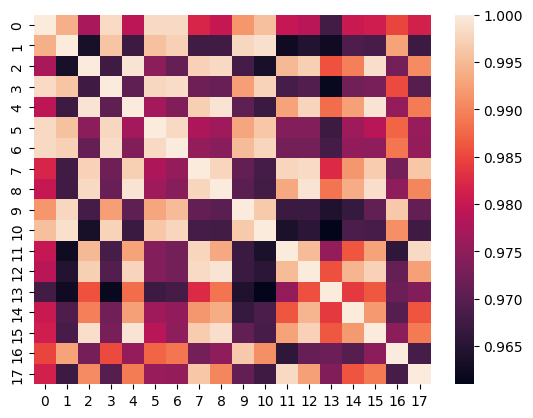

In [29]:
import seaborn as sns

data2 = cod_df.values.flatten().tolist()
data2_array = np.array(data2).reshape(len(cod_df.columns),len(cod_df.columns))
sns.heatmap(data2_array)

Here we see that the embeddings look very similar. I will continue the invastigation by checking the distribution of amino acids in the most similar and least similar sequence couples.

### Analysis of some proteins

In [31]:
minimum_cs = filtered_df.select(F.min(filtered_df["cosine_similarity"])).collect()


In [32]:
proteins = filtered_df.filter(filtered_df["cosine_similarity"] == minimum_cs[0][0]).collect()
protein1, protein2 = proteins[0][0],proteins[0][1]

In [45]:
seq_protein1 = tokens_df.select("tokens").where(f"id == '{protein1}'").take(1)
seq_protein2 = tokens_df.select("tokens").where(f"id == '{protein2}'").take(1)

#### Observing the frequencies of the residues of the most "different" sequences

In [46]:
Counter(seq_protein1[0][0])

Counter({'K': 17,
         'G': 10,
         'H': 6,
         'C': 6,
         'E': 6,
         'A': 5,
         'D': 4,
         'P': 4,
         'V': 3,
         'X': 3,
         'I': 2,
         'L': 2,
         'M': 2,
         'N': 1,
         'Q': 1,
         'F': 1,
         'T': 1})

In [44]:
Counter(seq_protein2[0][0])

Counter({'Q': 28,
         'A': 8,
         'L': 6,
         'Y': 6,
         'M': 3,
         'I': 3,
         'K': 2,
         'N': 2,
         'V': 2,
         'E': 2,
         'S': 1,
         'T': 1,
         'F': 1,
         'P': 1,
         'G': 1,
         'R': 1,
         'H': 1})

In [49]:
protein2

'2n72'

#### What are they
- Protein 1 is from 'Geobacter sulfurreducens KN400'
- Protein 2 is from 'Homo sapiens'

In [50]:
df_cos_sim.unpersist()

DataFrame[id1: string, id2: string, cosine_similarity: double]

#### Stopping the context and the spark app

In [51]:
sc.stop()

In [52]:
spark.stop()